In [3]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from pymongo import MongoClient
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

In [4]:
client = MongoClient(host="localhost",port=27017)
db = client["abtest-db"]
ds_app = db["ds-applicants"]
print("client:", type(client))
print("ds_app:", type(ds_app))

client: <class 'pymongo.synchronous.mongo_client.MongoClient'>
ds_app: <class 'pymongo.synchronous.collection.Collection'>


Calculate Power

One of a Data Scientist's jobs is to help others determine what's  meaningful information and what's not. You can think about this as distinguishing between **signal** and **noise**. As the author [Nate Silver](https://en.wikipedia.org/wiki/The_Signal_and_the_Noise) puts it, "The signal is the truth. The noise is what distracts us from the truth."

In our experiment, we're looking for a signal indicating that applicants who receive an email are more likely to complete the admissions quiz. If signal's strong, it'll be easy to see. A much higher number of applicants in our treatment group will complete the quiz. But if the signal's weak and there's only a tiny change in quiz completion, it will be harder to determine if this is a meaningful difference or just random variation. How can we separate signal from noise in this case? The answer is **statistical power**.

To understand what statistical power is, let's imagine that we're radio engineers building an antenna. The size of our antenna would depend on the type of signal we wanted to detect. It would be OK to build a low-power antenna if we only wanted to detect strong signals, like a car antenna that picks up your favorite local music station. But our antenna wouldn't pick up weaker signals — like a radio station on the other side of the globe. For weaker signals, we'd need something with higher power. In statistics, power comes from the number of observations you include in your experiment. In other words, the more people we include, the stronger our antenna, and the better we can detect weak signals. 

To determine exactly how many people we should include in our study, we need to do a **power calculation**. 

In [5]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.2,alpha=0.05, power=0.8))

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 197
Total # of applicants needed: 394


Use chi_square_power to plot a power curve for three effect sizes: 0.2, 0.5, and 0.8. The x-axis should be the number of observations, ranging from 0 to twice the group_size

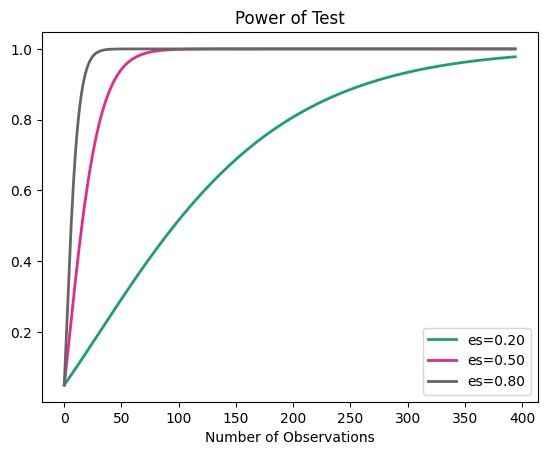

In [6]:
n_observations = np.arange(0, group_size*2 +1)
effect_sizes = np.array([0.2,0.5,0.8])


# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effect_sizes,
    alpha=0.05,
    n_bins=2
);

Calculate Subjects per Day
we decided that our experiment would focus on the subset of applicants who don't take the admissions quiz immediately after creating an account. We know we need around 400 observations from this subset, but how long do we need to run our experiment for in order to get that number?

In [9]:
result = ds_app.aggregate(
    [
        { "$match": {"admissionsQuiz": "incomplete"} },
        {
            "$group": {
                "_id": {
                    "$dateTrunc": {
                        "date": {
                            "$dateFromString": { "dateString": "$createdAt" }
                        },
                        "unit": "day"
                    }
                },
                "count": { "$sum": 1 }
            }
        }
    ]
)

print("result type:", type(result))

result type: <class 'pymongo.synchronous.command_cursor.CommandCursor'>


In [10]:
no_quiz = (
    pd.DataFrame(result)
    .rename({"_id": "date", "count": "new_users"}, axis=1)
    .set_index("date")
    .sort_index()
    .squeeze()
)

print("no_quiz type:", type(no_quiz))
print("no_quiz shape:", no_quiz.shape)
no_quiz.head()

no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)


date
2022-05-01    37
2022-05-02    49
2022-05-03    43
2022-05-04    48
2022-05-05    47
Name: new_users, dtype: int64

<Axes: xlabel='date'>

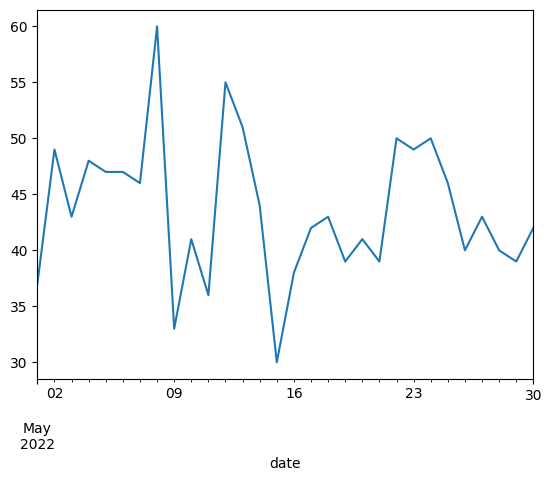

In [11]:
no_quiz.plot()


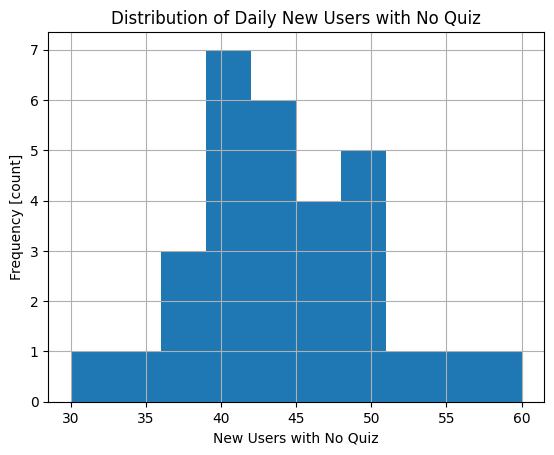

In [12]:
# Create histogram of `no_quiz`
no_quiz.hist()
# Add axis labels and title
plt.xlabel("New Users with No Quiz")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily New Users with No Quiz");

In [13]:
no_quiz.head().mean()
no_quiz.head().std()
no_quiz.describe()["std"]

np.float64(6.398275629767974)

In [14]:
mean = no_quiz.describe()["mean"]
std = no_quiz.describe()["std"]
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 43.6
no_quiz std: 6.398275629767974


The exact answers you'll get here will be a little different, but you should see a mean around 40 and a standard deviation between 7 and 8. Taking those rough numbers as a guide, how many days do we need to run the experiment to make sure we get to 400 users?

Intuitively, you might think the answer is 10 days, because  10⋅40=400
 . But we can't guarantee that we'll get 40 new users every day. Some days, there will be fewer; some days, more. So how can we estimate how many days we'll need? Statistics!

The distribution we plotted above shows how many no-quiz applicants come to the site each day, but we can use that mean and standard deviation to create a new distribution — one for the sum of no-quiz applicants over several days. Let's start with our intuition, and create a distribution for 10 days.

In [15]:
days = 10
sum_mean = mean * days
sum_std = std * np.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 436.0
Std of sum: 20.233124087615032


With this new distribution, we want to know what the probability is that we'll have 400 or more no-quiz applicants after 10 days. We can calculate this using the cumulative density function or CDF. The CDF will give us the probability of having 400 or fewer no-quiz applicants, so we'll need to subtract our result from 1.

In [16]:
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size*2,
    loc=sum_mean,
    scale=sum_std
)
prob_400_or_greater = 1 - prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Probability of getting 400+ no_quiz in 10 days: 0.981


exp = Experiment(repo=client, db="wqu-abtest", collection="ds-applicants")
exp.reset_experiment()
result = exp.run_experiment(days=days)
print("result type:", type(result))
result

In [17]:
ds_app = db["ds-applicants-after-exp"]
result = ds_app.find({"inExperiment": True})
print("results type:", type(result))

results type: <class 'pymongo.synchronous.cursor.Cursor'>


In [18]:
df = pd.DataFrame(result).dropna()

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (375, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,inExperiment,group
0,684bea9a9ad54a0bac7ba46e,2025-06-21T12:12:04,Andrew,Gonzales,andrew.gonzales25@gmall.com,1998-04-24T00:00:00,male,Bachelor's degree,IN,complete,True,email (t)
1,684bea9a9ad54a0bac7ba472,2025-06-18T05:11:28,Lee,Vanvalkenbur,lee.vanvalkenbur80@yahow.com,2000-08-05T00:00:00,male,Some College (1-3 years),ZM,complete,True,email (t)
2,684bea9a9ad54a0bac7ba484,2025-06-13T20:48:04,Kathleen,Read,kathleen.read70@yahow.com,1984-10-04T00:00:00,female,Bachelor's degree,KE,complete,True,email (t)
3,684bea9a9ad54a0bac7ba485,2025-06-14T13:14:24,Claudia,Krings,claudia.krings43@yahow.com,2001-10-17T00:00:00,female,Bachelor's degree,GH,complete,True,email (t)
4,684bea9a9ad54a0bac7ba489,2025-06-13T11:33:14,Mary,Myers,mary.myers98@yahow.com,1977-10-10T00:00:00,female,Bachelor's degree,NG,complete,True,email (t)


Build Contingency Table

Now that the results are in a DataFrame, we can start pulling apart what we found. Let's start by making a table showing how many people did and didn't complete the quiz across our two groups.

In [19]:
df[["group", "admissionsQuiz"]].head()

,group,admissionsQuiz
0,email (t),complete
1,email (t),complete
2,email (t),complete
3,email (t),complete
4,email (t),complete


In [20]:
pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=True
)

admissionsQuiz,complete,incomplete
group,,
email (t),0.037333,0.464
no email (c),0.026667,0.472


In [21]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=True
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),0.037333,0.464
no email (c),0.026667,0.472


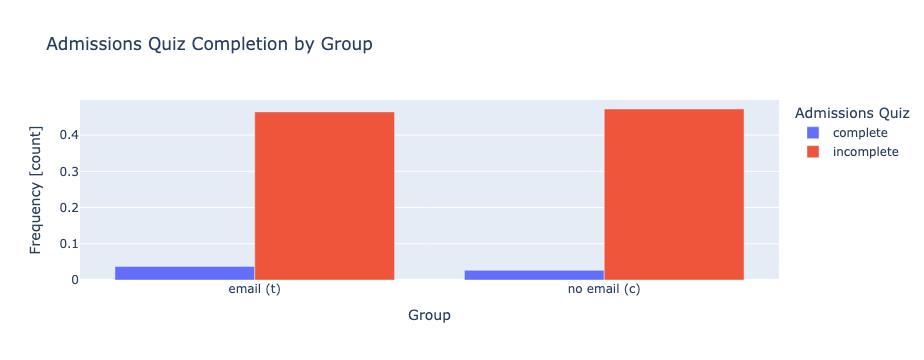

In [22]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title="Group",
        yaxis_title="Frequency [count]",
        legend={"title": "Admissions Quiz"}
    )
    return fig


build_contingency_bar().show()